In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [89]:
nn = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

In [90]:
optimal = tf.keras.optimizers.Adam(learning_rate=0.001)

In [91]:
def odd_system(t, net):
    t = t.reshape(-1, 1)
    t = tf.constant(t, dtype=tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)
        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    sqare_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(sqare_loss)

    return total_loss

In [92]:
train_t = (np.random.rand(50)*2).reshape(-1,1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = odd_system(train_t, nn)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, nn.trainable_variables)
        optimal.apply_gradients(zip(grad_w, nn.trainable_variables))

In [93]:
test_t = (np.random.rand(50) * 2).reshape(-1, 1)

In [94]:
predictions = nn.predict(test_t)

2/2 [==============================] - 0s 1000us/step


In [95]:
def true_sol(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

In [96]:
import seaborn as sns

In [97]:
sort_val = np.sort(test_t.reshape(1,-1))

In [98]:
cur = np.arange(0, 2, 0.01)

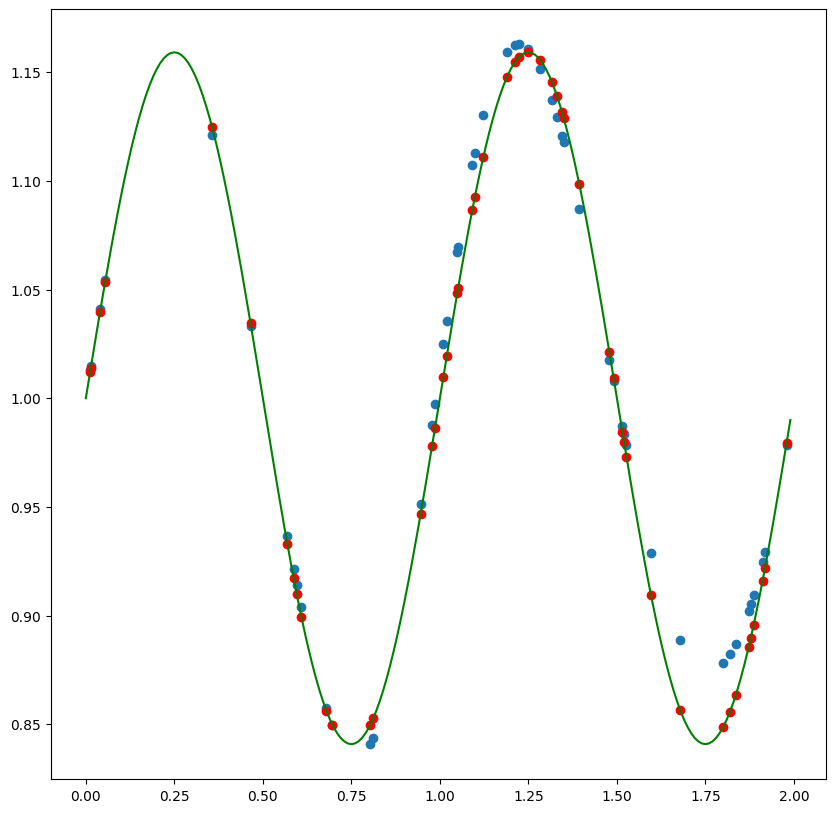

In [99]:
plt.figure(figsize=(10, 10))
plt.scatter(test_t, predictions)
plt.scatter(test_t, [true_sol(i) for i in test_t]  , color='red')
plt.plot(cur, [true_sol(i) for i in cur], color='green')
plt.show()

In [100]:
from function import *

In [101]:
df = make_data(dt=0.01, total_time = 50)

In [102]:
df

,u,time,f
0,0.000000e+00,0.00,0.000000
1,6.279052e-02,0.01,0.152729
2,1.253332e-01,0.02,0.272857
3,1.873813e-01,0.03,0.369560
4,2.486899e-01,0.04,0.449713
...,...,...,...
4996,-2.486899e-01,49.96,0.299277
4997,-1.873813e-01,49.97,0.338483
4998,-1.253332e-01,49.98,0.375216
4999,-6.279052e-02,49.99,0.410140


In [103]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [104]:
train_x = train.iloc[:, :2].values
train_y = train.iloc[:, 2].values
test_x = test.iloc[:, :2].values
test_y = test.iloc[:, 2].values

In [105]:
train_x = tf.cast(train_x, dtype=tf.float32)

In [106]:
inputs = tf.keras.Input(shape=(2,))
x = tf.keras.layers.Dense(32, activation='sigmoid')(inputs)
z_pred = tf.keras.layers.Dense(1, name='z_pred')(x)
f_pred = tf.keras.layers.Dense(1, name='f_pred')(x)
nn_2 = tf.keras.Model(inputs=inputs, outputs=[z_pred, f_pred])


In [129]:
A = tf.constant(3, dtype=tf.float32)  
B = tf.constant(5, dtype=tf.float32)  
G = tf.constant(1, dtype=tf.float32)  
n = tf.constant(1, dtype=tf.float32)

In [139]:
def bouc_wen(u, net, A, B, G, z, n):
    with tf.GradientTape() as tape:
        tape.watch(u)
        z_pred, f_pred = net(u)
    
    Z_dot_pred = tape.gradient(z_pred, u)
    Z_dot_pred = tf.cast(Z_dot_pred, dtype=tf.float32)
    f_pred = tf.cast(f_pred, dtype=tf.float32)
    
    # Assuming compute_boucwen_dynamics returns the true_function
    true_function = compute_boucwen_dynamics(u, z, A, B, G, n)
    true_function = tf.cast(true_function, dtype=tf.float32)
    
    # Compute loss
    physics_loss = tf.reduce_mean(tf.square(true_function - f_pred))
    data_loss = tf.reduce_mean(tf.square(train_y - f_pred))
    total_loss = 0.5 * physics_loss + 0.5 * data_loss

    return total_loss


In [168]:
u_diff = np.diff(train_x[:,0])

In [169]:
t_diff = np.diff(train_x[:,1])

In [177]:
[u_diff, t_diff]

[array([0.06279052, 0.06254271, 0.06204808, ..., 0.06130858, 0.06204808,
        0.06254271], dtype=float32),
 array([0.01      , 0.01      , 0.01      , ..., 0.01000214, 0.00999832,
        0.01000214], dtype=float32)]

In [173]:
train_y[:3999]

array([0.        , 0.15272865, 0.27285674, ..., 0.29948548, 0.33863693,
       0.3753289 ])

In [157]:
train_y

array([0.        , 0.15272865, 0.27285674, ..., 0.33863693, 0.3753289 ,
       0.41022182])

In [140]:
optimal = tf.keras.optimizers.Adam(learning_rate=0.001)
optimal.build(nn_2.trainable_variables)

train_loss_record_2 = []
for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = bouc_wen(train_x, nn_2, A, B, G, tf.constant(1, dtype = tf.float32), n)
        train_loss_record_2.append(train_loss)

        grad_w = tape.gradient(train_loss, nn_2.trainable_variables)
        optimal.apply_gradients(zip(grad_w, nn_2.trainable_variables))


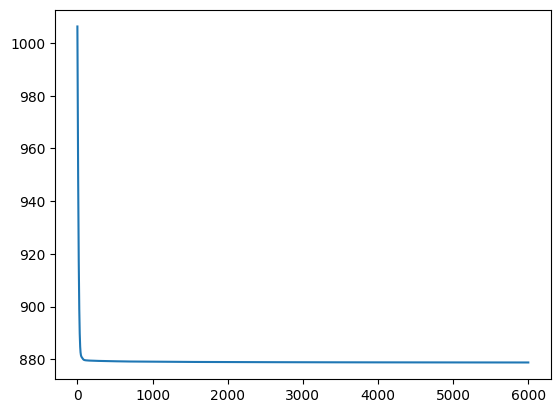

In [141]:
plt.plot(train_loss_record_2)

In [142]:
pred_2 = nn_2.predict(test_x)

32/32 [==============================] - 0s 589us/step


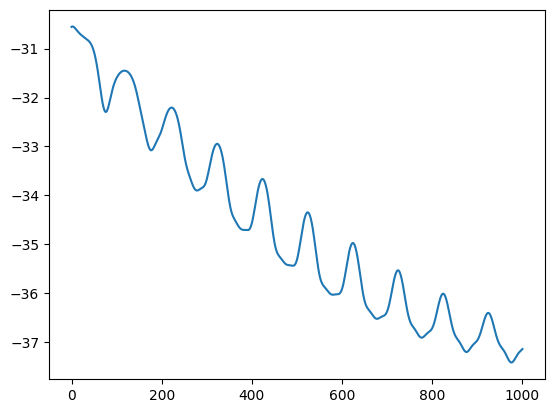

In [145]:
plt.plot(pred_2[1])

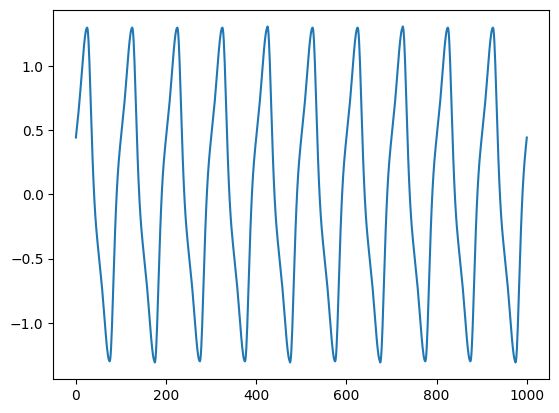

In [144]:
plt.plot(test_y)